In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl

In [50]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [59]:
dir = '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog'

In [62]:
images = []
labels = []
for directory in os.listdir(dir):
  for subDir in os.listdir(os.path.join(dir,directory)):
    for img in os.listdir(os.path.join(dir, directory, subDir)):
      img_path = os.path.join(dir, directory, subDir, img)
      images.append(img_path)
      labels.append(subDir)

In [63]:
Iseries = pd.Series(images, name="Images")
Lseries = pd.Series(labels, name="labels")
hand_gesture_data = pd.concat([Iseries, Lseries], axis=1)
hand_gesture = pd.DataFrame(hand_gesture_data)

In [64]:
print(hand_gesture.head())

                                              Images labels
0  /kaggle/input/leapgestrecog/leapgestrecog/leap...   02_l
1  /kaggle/input/leapgestrecog/leapgestrecog/leap...   02_l
2  /kaggle/input/leapgestrecog/leapgestrecog/leap...   02_l
3  /kaggle/input/leapgestrecog/leapgestrecog/leap...   02_l
4  /kaggle/input/leapgestrecog/leapgestrecog/leap...   02_l


In [65]:
pd.Series(labels).value_counts()

02_l             2000
04_fist_moved    2000
09_c             2000
10_down          2000
06_index         2000
08_palm_moved    2000
07_ok            2000
05_thumb         2000
01_palm          2000
03_fist          2000
Name: count, dtype: int64

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(hand_gesture, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(hand_gesture, test_size=0.3, random_state=42)

In [118]:
image_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(
    dataframe= train_set,
    x_col="Images",
    y_col="labels",
    target_size=(244,244),
    class_mode="categorical",
    batch_size=4,
    shuffle=False)
test = image_gen.flow_from_dataframe(
    dataframe= X_test,x_col="Images",
    y_col="labels",
    target_size=(244,244),
    class_mode="categorical",
    batch_size=4,
    shuffle= False )
val = image_gen.flow_from_dataframe(
    dataframe= val_set,
    x_col="Images",
    y_col="labels",
    target_size=(244,244),
    class_mode="categorical",
    batch_size=4,
    shuffle=False  )

Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [114]:
classes=list(train.class_indices.keys())
print (classes)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [122]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 73, 73, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 73, 73, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 24, 24, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 24, 24, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 6, 6, 64)       │           25

 Total params: 265,770 (1.01 MB)

 Trainable params: 264,938 (1.01 MB)

 Non-trainable params: 832 (3.25 KB)

In [123]:
history = model.fit(train, epochs=3, validation_data=val, verbose=1)

Epoch 1/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 539s 153ms/step - accuracy: 0.3009 - loss: 2.0635 - val_accuracy: 0.9782 - val_loss: 0.1560
Epoch 2/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 513s 146ms/step - accuracy: 0.8363 - loss: 0.4779 - val_accuracy: 0.9962 - val_loss: 0.0181
Epoch 3/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 514s 147ms/step - accuracy: 0.9430 - loss: 0.1720 - val_accuracy: 0.9992 - val_loss: 0.0040


In [125]:
model.evaluate(test, verbose=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9993 - loss: 0.0039


[0.004004199057817459, 0.9992499947547913]

In [126]:
model.save("hand_gesture_Model.h5")

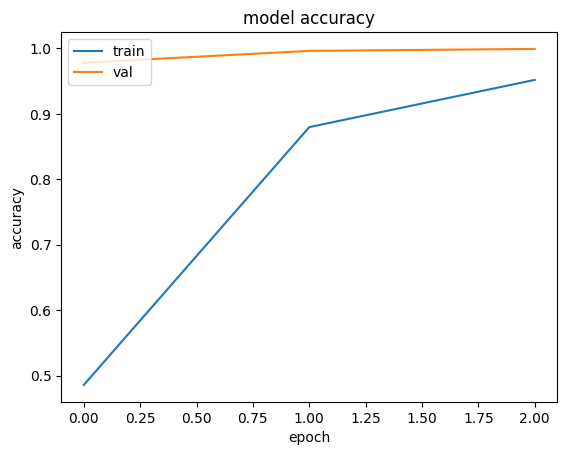

In [128]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()